# Regression Analysis Tutorial – Lasso and Ridge Regularization  
**Creator: Muhammad Bilal Alam**

---

## What is Lasso Regression (L1)?

Lasso regression, also known as **L1 regularization**, is a linear regression technique that adds a penalty term to the cost function. This penalty **shrinks coefficients toward zero** and enables **automatic variable selection**.

- The penalty term is the absolute value of the coefficients multiplied by a constant **alpha (α)**.
- A **smaller α** → weaker penalty → larger coefficients.  
- A **larger α** → stronger penalty → more coefficients shrink to zero.

### **Lasso Cost Function**:
$$
\text{Cost} = \text{RSS} + \alpha \sum_{i=1}^{n} |\beta_i|
$$

**Where:**  

\- <b>RSS</b> = Residual Sum of Squares  
\- <b>α</b> = Regularization parameter  
\- <b>∑|βᵢ|</b> = Sum of absolute values of all coefficients  





The goal is to **minimize** this cost function by tuning coefficients.

---

## What is Ridge Regression (L2)?

Ridge regression adds **L2 regularization** to a linear regression model. It helps prevent **overfitting** by penalizing large coefficient values.

- The penalty is proportional to the **sum of squared** coefficient values.
- As α increases, the model becomes simpler due to coefficient shrinkage.

### **Ridge Loss Function**:
**Ridge Loss Function**:

<p style="text-align: left;">
<b>Loss Function (Ridge Regression):</b>  
</p>

$$
\text{Loss} = \text{RSS} + \alpha \sum_{i=1}^{n} \beta_i^2
$$


<b>Where:</b><br>
<p style="text-align: left;">
- <b>RSS</b> = Residual Sum of Squares<br>
- \(\sum_{i=1}^{n} \beta_i^2 = \text{Sum of squares of all } n \text{ coefficients}\)<br>
- \(\alpha = \text{Regularization strength (tuned via cross-validation)}\)
</p>




Ridge is especially helpful when predictor variables are **highly correlated** (i.e., multicollinearity).

---

## Difference Between Lasso and Ridge

### Ridge Regression:
- Best used when predictors are **highly correlated**.
- Addresses **multicollinearity** by shrinking coefficients.
- Retains all features but reduces their impact.

### Lasso Regression:
- Best used when there are **many irrelevant or weak predictors**.
- Performs **feature selection** by setting some coefficients to **exactly zero**.
- Simplifies the model and reduces overfitting.

### Summary:
- Use **Ridge** → when dealing with **multicollinearity**.
- Use **Lasso** → when performing **feature selection** in high-dimensional datasets.


### Step 1: Import Required Libraries

In [1]:
# ── Data manipulation and visualization ─────────────────────────────────────────
import pandas as pd                    # Tabular data handling (DataFrame)
import numpy as np                     # Numerical operations on arrays / matrices
import matplotlib.pyplot as plt        # Basic plotting
import seaborn as sns                  # Statistical data visualization (built on matplotlib)

# ── Model training and evaluation (scikit-learn) ───────────────────────────────
from sklearn.linear_model import Lasso  # L1-regularized linear regression
from sklearn.linear_model import Ridge  # L2-regularized linear regression
from sklearn.preprocessing import StandardScaler  # Feature scaling (mean-0 / std-1)
from sklearn.model_selection import train_test_split  # Train / test split
from sklearn.model_selection import GridSearchCV     # Hyperparameter tuning with CV
from sklearn.metrics import mean_squared_error, r2_score  # Regression metrics

# ── Suppress warnings for cleaner output ───────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

### Step 2: Load and Explore the Dataset

We'll be working with the California Housing dataset, a commonly used dataset for regression problems. It includes features like average income, number of rooms, population, and median house value for various districts in California.

We'll load the dataset directly using sklearn.datasets, convert it to a pandas DataFrame, and preview the first few rows.

In [2]:
from sklearn.datasets import fetch_california_housing

# Load dataset
housing_data = fetch_california_housing()

# Convert to DataFrame
df = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
df['MedHouseVal'] = housing_data.target  # Add target variable

# Preview the dataset
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Step 3 (a): Inspect Dataset Shape and Basic Information  

Before diving deeper, we confirm the overall structure of the California Housing dataset:

* **Shape** – Number of rows (observations) and columns (features + target).  
* **Info** – Data types, non-null counts, and memory usage.  

These quick checks help verify:

1. Dataset dimensions (e.g., `(20 640, 9)` means 20,640 rows, 9 columns).  
2. Presence of missing values or unexpected data types.


In [3]:
# Shape of the DataFrame (rows, columns)
print("Data shape:", df.shape)  # Expect (20640, 9)

# Detailed info: column names, non-null counts, dtypes, memory usage
df.info()

Data shape: (20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Step 3 (b): Descriptive Statistics

Descriptive statistics provide a quick summary of the central tendency, dispersion, and shape of a dataset’s distribution.

Key metrics include:
- **Count**: Number of non-null entries
- **Mean** and **Std**: Measure of central tendency and spread
- **Min/Max** and Quartiles (25%, 50%, 75%): Help in detecting outliers

From this, we can identify:
- **Outliers**: Columns like `AveRooms`, `AveBedrms`, `Population`, and `AveOccup` show high max values.
- **Normal Distribution**: Columns like `MedInc`, `HouseAge`, and `MedHouseVal` are relatively well-behaved.
- **Skewness**: `Latitude` is left-skewed, `Longitude` is right-skewed.


In [4]:
# Display descriptive statistics for all numeric features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


### Step 3 (c): Check for Missing Values

Before training any machine learning model, it is crucial to check for missing values in the dataset.

Most ML algorithms do not handle missing data well. If any are found, they must be imputed or removed to prevent training issues or bias.

In this case, we'll use `.isnull().sum()` to inspect each column.


In [5]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


### Step 3 (d): Check for Duplicate Values

Duplicate records can negatively affect model performance by biasing the learning process.

It’s good practice to check and optionally remove any duplicated rows before proceeding with feature engineering or model training.


In [6]:
# Check for duplicate values
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


### Step 3 (e): Detecting Outliers Using Boxplots

Outliers can distort statistical analyses and lead to misleading results in models — especially for regression-based models.

We use boxplots to visually detect outliers in key numerical features.

Below, we generate boxplots for selected features with noticeable variance or potential outliers.

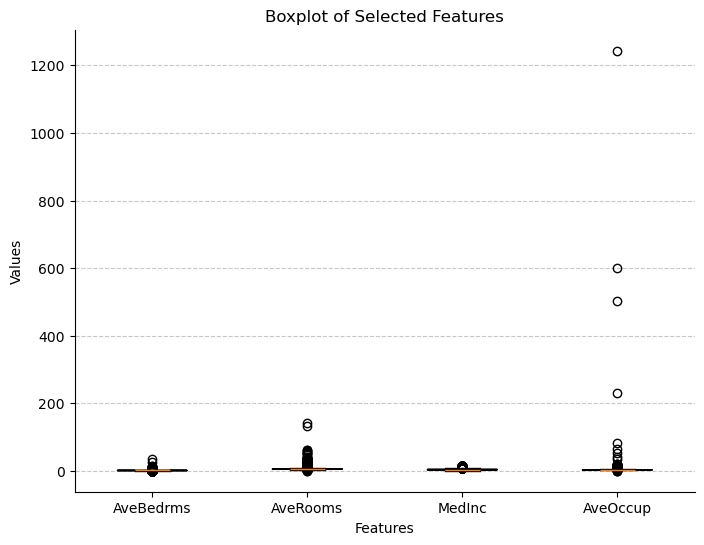

In [7]:
# Define the colors for each feature
colors = ['blue', 'red', 'green', 'purple']

# Select features to plot
features = ['AveBedrms', 'AveRooms', 'MedInc', 'AveOccup']

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a boxplot for each feature
bp = ax.boxplot([df[f] for f in features],
                sym='o',
                patch_artist=True,
                notch=True)

# Assign unique colors to each feature
for patch, color in zip(bp['boxes'], colors[:len(features)]):
    patch.set_facecolor(color)

# Customize the x-axis tick labels
ax.set_xticklabels(features)
ax.set_title('Boxplot of Selected Features')
ax.set_xlabel('Features')
ax.set_ylabel('Values')

# Add grid lines and remove top and right spines
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the size of the plot
fig.set_size_inches(8, 6)
plt.show()

### Step 3 (f): Handling Outliers with Winsorization

We observed from the boxplots that several features contain extreme outliers.

To reduce their influence on our model, we apply **Winsorization**, a technique that caps extreme values at defined percentile thresholds.

This helps maintain the structure of the data while reducing the impact of outliers.

In [8]:
# Define percentile limits
pct_lower = 0.01
pct_upper = 0.95

# Apply Winsorization to selected columns
df['AveRooms'] = np.clip(df['AveRooms'],
                         df['AveRooms'].quantile(pct_lower),
                         df['AveRooms'].quantile(pct_upper))

df['AveBedrms'] = np.clip(df['AveBedrms'],
                          df['AveBedrms'].quantile(pct_lower),
                          df['AveBedrms'].quantile(pct_upper))

df['Population'] = np.clip(df['Population'],
                           df['Population'].quantile(pct_lower),
                           df['Population'].quantile(pct_upper))

df['AveOccup'] = np.clip(df['AveOccup'],
                         df['AveOccup'].quantile(pct_lower),
                         df['AveOccup'].quantile(pct_upper))

df['MedInc'] = np.clip(df['MedInc'],
                       df['MedInc'].quantile(pct_lower),
                       df['MedInc'].quantile(pct_upper))

### Step 3 (f)(ii): Visualize Features After Winsorization  
To confirm that outliers have been effectively capped, we re-plot the same boxplots.  
The post-winsorization plots should show shorter whiskers and fewer extreme points, indicating a more robust distribution for downstream modeling.

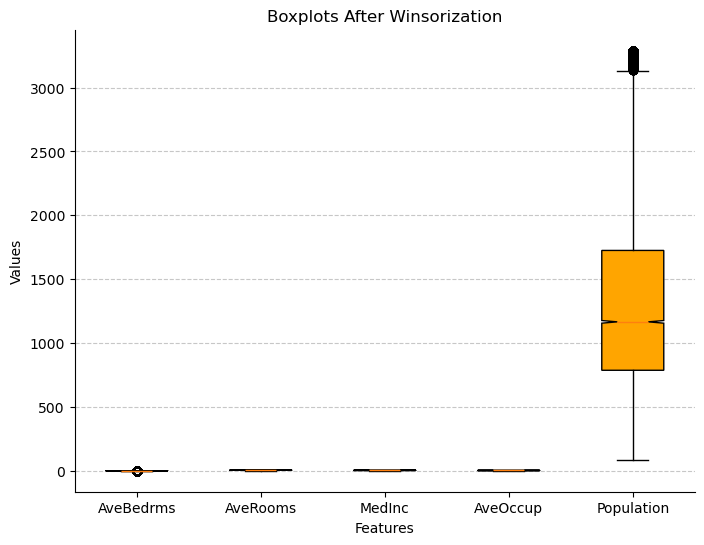

In [9]:
# Re-plot boxplots for the winsorized features
features = ['AveBedrms', 'AveRooms', 'MedInc', 'AveOccup', 'Population']
colors   = ['blue', 'red', 'green', 'purple', 'orange']

fig, ax = plt.subplots()
bp = ax.boxplot([df[f] for f in features],
                sym='o',
                patch_artist=True,
                notch=True)

# Apply colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(features)
ax.set_title('Boxplots After Winsorization')
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.set_size_inches(8, 6)
plt.show()

### Step 3 (g): Check for Skewness Using Histograms

Visualizing histograms for each numerical feature helps identify skewness and data distribution.  
Skewed data can impact model accuracy and assumptions.  
By plotting these histograms with a vertical mean line, we can visually assess whether transformations are necessary.

Note: We'll also inspect the target variable `MedHouseVal` for any skewness, though minor skewness might not require transformation.


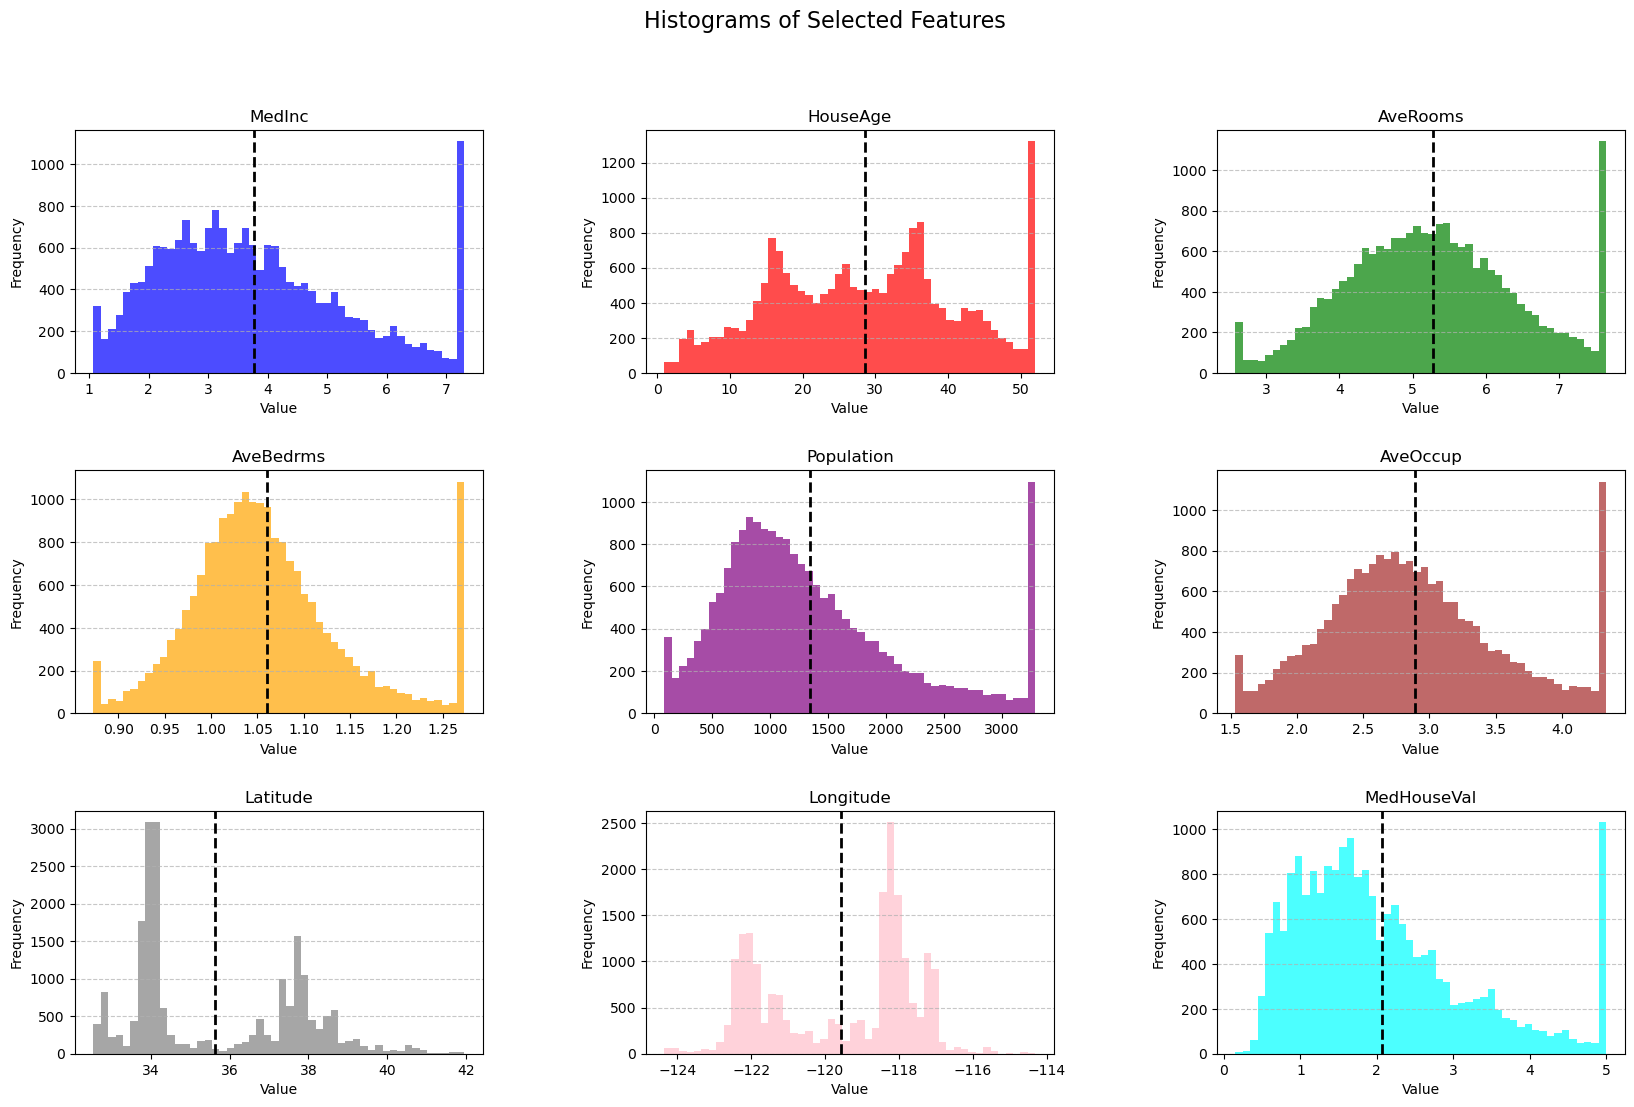

In [10]:
# Select all numeric features
features = df.columns

# Define unique colors for each plot
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'gray', 'pink', 'cyan']

# Set up the plot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
axs = axs.flatten()
fig.suptitle('Histograms of Selected Features', fontsize=16)

# Loop through each feature to plot histogram
for i, feature in enumerate(features):
    data = df[feature].values
    mean_val = np.mean(data)
    
    axs[i].hist(data, bins=50, color=colors[i], alpha=0.7)
    axs[i].axvline(mean_val, color='black', linestyle='--', linewidth=2)
    axs[i].set_title(f'{feature}', fontsize=12)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


### Step 3 (h): Create a Vertical Correlation Heatmap

Correlation heatmaps help visualize linear relationships between variables in the dataset.  
This can guide feature selection and multicollinearity analysis for regression models.

- Correlation values range from **-1 to 1**:
  - **+1** = Perfect positive linear correlation
  - **-1** = Perfect negative linear correlation
  - **0** = No linear correlation

By observing this heatmap, we can identify strongly correlated features (either positively or negatively) with the target variable `MedHouseVal`.


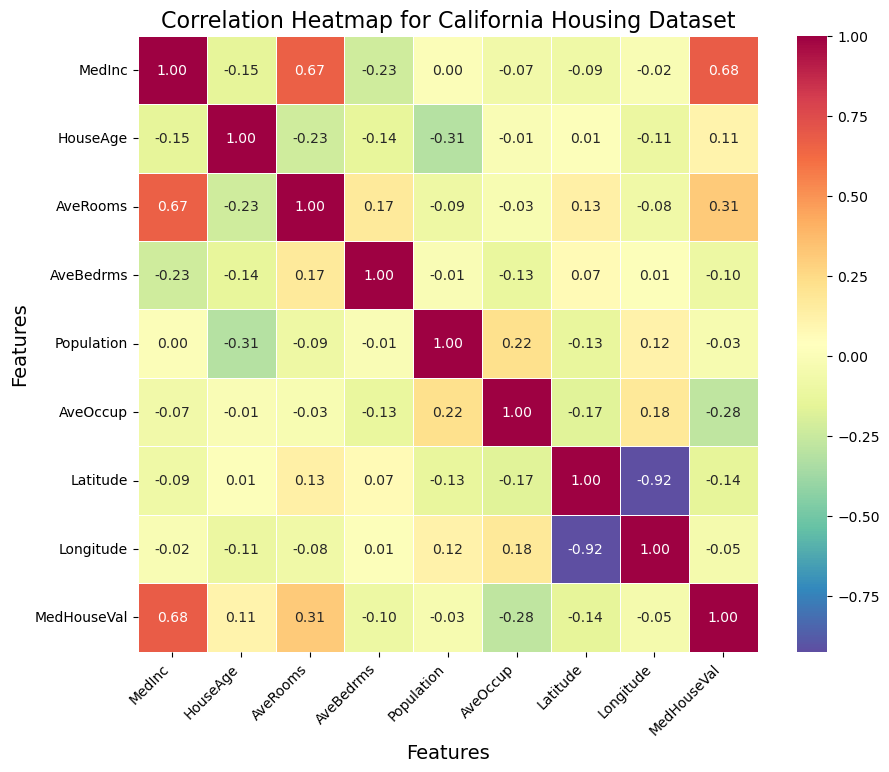

In [11]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap using seaborn
sns.heatmap(corr_matrix, 
            cmap='Spectral_r', 
            annot=True, 
            fmt='.2f', 
            linewidths=0.5, 
            ax=ax)

# Add title and axis labels
ax.set_title('Correlation Heatmap for California Housing Dataset', fontsize=16)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Features', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()


### Step 3 (i): Perform Feature Scaling

Feature scaling is crucial in regularized regression models like Lasso and Ridge because these models are sensitive to the scale of features.

Without scaling, features with larger ranges could dominate the penalty term and bias the model.  
By applying **StandardScaler**, we ensure:
- Mean of each feature = 0
- Standard deviation = 1

This improves model performance and stabilizes coefficient estimation.


In [12]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the dataset
df_scaled = scaler.fit_transform(df)

# Convert scaled array back to a DataFrame with original column names
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

### Step 3 (j): Assumption Check with Scatter Plots  

Linear models—especially Lasso and Ridge—assume a linear relationship between each predictor and the target variable (`MedHouseVal`).  
To visually verify this assumption, we plot each (scaled) feature against the unscaled target.

Key things to look for:
- **Linear trend** → good fit for linear regression.
- **Non-linear curves / clouds** → may require transformation or interaction terms.
- **Heteroscedasticity** (fan-shaped spread) → can affect model reliability.


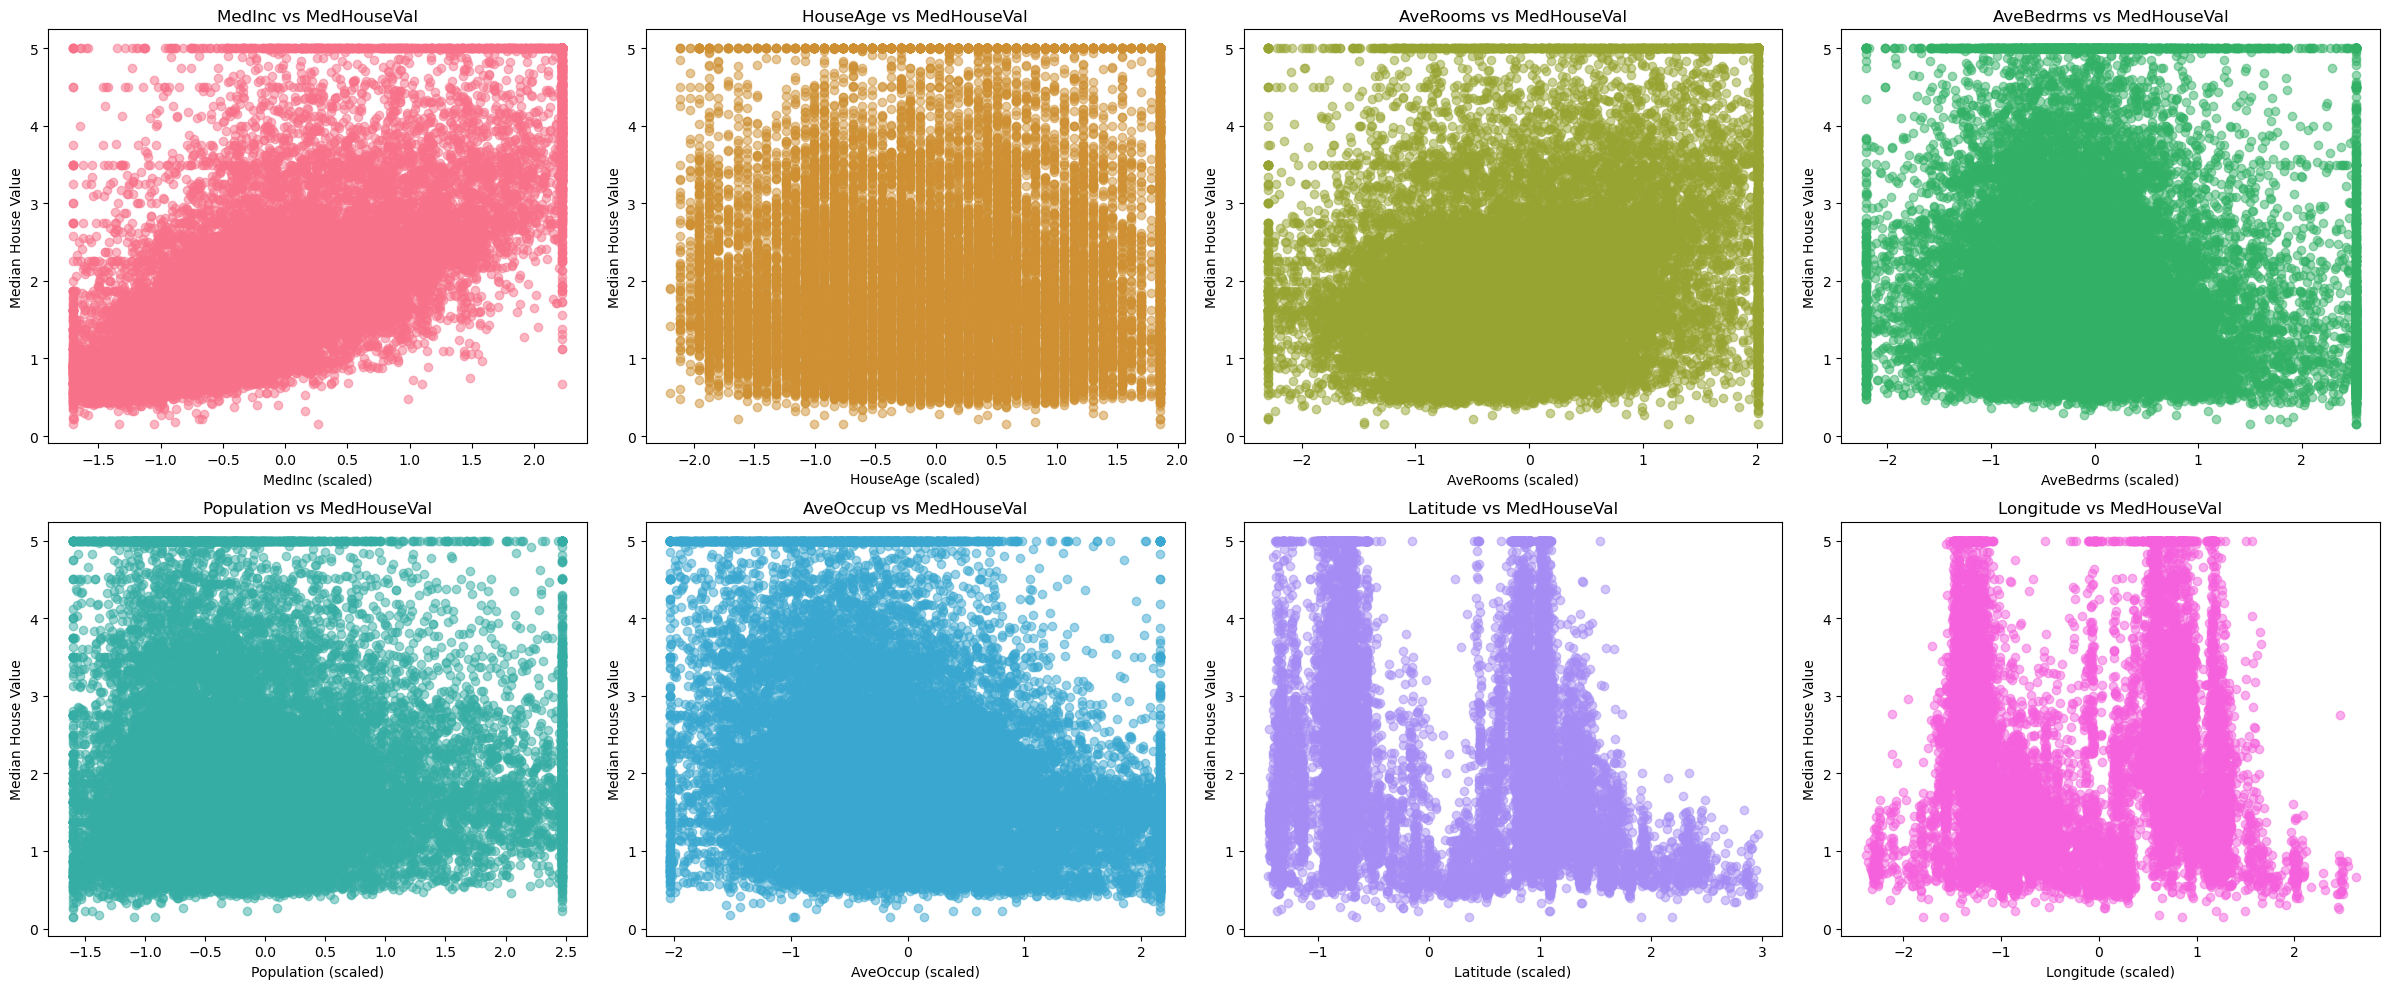

In [13]:
# List of predictors (all columns except the target)
predictors = df_scaled.columns.drop('MedHouseVal')

# Create a 2×4 subplot grid (8 features in total)
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

# Color palette for variety
palette = sns.color_palette("husl", len(predictors))

for idx, feature in enumerate(predictors):
    axes[idx].scatter(df_scaled[feature], df['MedHouseVal'],
                      color=palette[idx], alpha=0.5)
    axes[idx].set_title(f'{feature} vs MedHouseVal')
    axes[idx].set_xlabel(f'{feature} (scaled)')
    axes[idx].set_ylabel('Median House Value')

plt.tight_layout()
plt.show()

### Step 4: Define Dependent and Independent Variables

Before training our models, we must separate the features (independent variables) from the target (dependent variable).

- **X**: All columns **except** `MedHouseVal` — these are the predictors used to estimate house value.
- **y**: The `MedHouseVal` column — this is the value we aim to predict.


In [14]:
# Define features (X) and target (y)
X = df_scaled.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']  # Keep target unscaled for interpretability

### Step 5: Perform Lasso (L1) Regression

Lasso Regression adds L1 regularization to the linear model, shrinking less important feature coefficients to zero. This not only reduces overfitting but also acts as a feature selection mechanism.

---

#### Step 5(a): Use `LassoCV` to Find the Best Alpha

`LassoCV` automates the search for the best value of alpha (the regularization strength) by evaluating model performance across a range of alpha values using cross-validation.


In [15]:
# Import LassoCV
from sklearn.linear_model import LassoCV

# Create a LassoCV model with 5-fold cross-validation
lasso_cv = LassoCV(cv=5)

# Fit the model
lasso_cv.fit(X, y)

# Print the best alpha value found
print("Best alpha (Lasso):", lasso_cv.alpha_)


Best alpha (Lasso): 0.0007860894985619018


#### Step 5(b): Feature Selection with `SelectFromModel`

After finding the best regularization strength using `LassoCV`, we use `SelectFromModel` to automatically select the most relevant features. This method keeps only the features with non-zero coefficients—effectively performing dimensionality reduction.


In [16]:
# Import SelectFromModel
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# Initialize a Lasso model with the best alpha from LassoCV
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)

# Use SelectFromModel to identify important features
selector = SelectFromModel(estimator=lasso)
X_selected = selector.fit_transform(X, y)

# Get the names of selected features
selected_features = X.columns[selector.get_support()]
print("Selected features using Lasso:", selected_features.tolist())


Selected features using Lasso: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


#### Step 5(c): Fit Lasso Model on Selected Features

Now that we've selected the most important features using `SelectFromModel`, we train a Lasso regression model using only those features. This step helps simplify the model and reduces the risk of overfitting by eliminating irrelevant or less important variables.


In [17]:
# Split the selected features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Reinitialize LassoCV to refit on selected features
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

# Predict on test set
y_pred = lasso_cv.predict(X_test)


#### Step 5(d): Evaluate Lasso Model Performance

To assess how well our Lasso regression model performs, we compute two key metrics:

- **Root Mean Squared Error (RMSE):** Measures the average magnitude of prediction errors.
- **R² Score (Coefficient of Determination):** Indicates the proportion of the variance in the target variable explained by the model.

These metrics help us understand both accuracy and explanatory power of the regression model.


In [18]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)


Root Mean Squared Error (RMSE): 0.6769478184580205
R² Score: 0.6508614508715184


The Lasso model achieved an RMSE of ≈ 0.68 and an R² of ≈ 0.65 on the test set.

An R² of 0.65 means the model explains about 65 % of the variance in median house value—respectable for a linear model with automatic feature selection.

An RMSE of 0.68 (in the dataset’s target units) indicates the average prediction error magnitude.

Overall, Lasso provides a moderate fit while simplifying the model by zeroing out less-important features. Further gains might come from tuning α more finely, trying interaction terms, or using non-linear models (e.g., Gradient Boosting, Random Forest).

#### Step 6(a): Split Data for Ridge Regression

Before applying Ridge regression, we prepare the data by splitting the original feature set (before `SelectFromModel`) into training and testing sets.


In [19]:
# Split the data into training and testing sets (same as before, 70:30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#### Step 6(b): Use RidgeCV to Find the Best Alpha

To find the optimal regularization strength for Ridge regression, we use `RidgeCV`, which performs cross-validation over a set of alpha values.

- **RidgeCV:** Automatically tunes the alpha parameter using cross-validation.
- **Alpha (Regularization Parameter):** Controls the amount of shrinkage applied to the coefficients.

This helps prevent overfitting and ensures our Ridge model generalizes well on unseen data.


In [20]:
# Step 6(b): Use RidgeCV to Find the Best Alpha

from sklearn.linear_model import RidgeCV

# Initialize RidgeCV with 5-fold cross-validation
ridge_cv = RidgeCV(cv=5)

# Fit model on training data
ridge_cv.fit(X_train, y_train)

# Print best alpha value
print("Best alpha value:", ridge_cv.alpha_)


Best alpha value: 1.0


RidgeCV has selected an optimal alpha value of 1.0, which means:

- Regularization is applied, but moderately — large enough to reduce overfitting without overly shrinking the coefficients.

- A balanced trade-off between bias and variance has likely been achieved.

This alpha will now be used to fit the final Ridge regression model.

#### Step 6(c): Perform Ridge Regression

Now that we have the optimal alpha value (1.0), we fit the Ridge regression model to the training data using this parameter.

- This step will train the model using **all features**, including those not selected by Lasso.
- Regularization will help control multicollinearity and improve model generalization.


In [21]:
# Step 6(c): Perform Ridge Regression

from sklearn.linear_model import Ridge

# Create Ridge model with the best alpha
ridge = Ridge(alpha=ridge_cv.alpha_)

# Fit model on training data
ridge.fit(X_train, y_train)

# Predict on test data
y_pred = ridge.predict(X_test)

#### Step 6(d): Evaluate Ridge Model Performance

To evaluate the performance of our Ridge regression model, we compute:

- **Root Mean Squared Error (RMSE):** Measures the model's average prediction error.
- **R² Score (Coefficient of Determination):** Indicates the proportion of the variance in the target variable explained by the model.

These metrics help assess both accuracy and explanatory strength of our regression model.


In [22]:
# Evaluate Ridge model performance

# Compute Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Compute R² Score
r2 = r2_score(y_test, y_pred)

# Display results
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Squared Error: 0.45834461724901443
R² Score: 0.6507957246255714


- **Mean Squared Error (MSE):** `0.4583` — This indicates the average of the squared prediction errors.
- **R² Score (Coefficient of Determination):** `0.6508` — Roughly 65% of the variance in the target variable is explained by the model.

These results show that the Ridge model performs reasonably well, comparable to Lasso regression, and handles multicollinearity without overfitting.

### Conclusion: Comparing Lasso and Ridge Regression

In this notebook, we explored **Lasso (L1)** and **Ridge (L2)** regression techniques using the California Housing dataset.

**Key Takeaways:**

- **Lasso Regression:**
  - Selected key features by shrinking some coefficients to zero.
  - RMSE: ~0.677
  - R² Score: ~0.651
  - Useful for feature selection and reducing model complexity.

- **Ridge Regression:**
  - Retained all features but penalized large coefficients.
  - MSE: ~0.458
  - R² Score: ~0.651
  - Effective for handling multicollinearity and improving generalization.

While both models performed similarly in terms of R², **Ridge had a slightly lower error**, suggesting better stability. **Lasso**, however, can be more useful when interpretability and feature selection are key goals.

> These techniques show the power of regularization in building robust linear models, especially when dealing with noisy or high-dimensional data.